In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import pickle
import time

In [2]:
FIGSIZE = (14,8)

In [3]:
np.random.seed(100)

In [4]:
with open('..//data//simulated_covar_matrices.pickle', 'rb') as f:
    covar_matrices = pickle.load(f)

In [5]:
len(covar_matrices)

10000

In [6]:
np.diag(covar_matrices[0])**(0.5)

array([0.01772747, 0.01137493, 0.01029109, 0.01551634, 0.01080268,
       0.00975606, 0.0082655 , 0.01016475, 0.01246961, 0.02410599,
       0.03126094])

In [8]:
# 252 days is found in another notebook

def calc_risk_free_rate(annual_rate = 0.02, days=252):
    return np.exp(np.log(1 + annual_rate) / days) - 1
    
rf = calc_risk_free_rate()

In [26]:
print(rf)

7.85849419846496e-05


In [9]:
def sample_means(n=11):
    # found from maximum likelihood estimation
    mu, sigma = 0.001231415380377799, 0.0004612333818775558
    return np.random.normal(mu, sigma, size=n)

In [10]:
def calc_tangency_portfolio(mu, covars, rf):
    ones, covars_inv = np.ones(len(means)), np.linalg.inv(covars)

    risk_adjusted_mu = (mu - (rf * ones))
    
    numer = np.dot(covars_inv, risk_adjusted_mu)
    denom = np.dot(ones.T, numer)
    return numer / denom
    

In [11]:
def gen_names(prefix = 'weights', array_length=11):
    if prefix == 'weights':
        return [f"w_{ix}" for ix in range(1, array_length + 1)]
    elif prefix == 'stocks':
        return [f"s_{ix}" for ix in range(1, array_length + 1)]
    else:
        raise ValueError('prefix must be either stocks or weights')

In [12]:
means = sample_means()
calc_tangency_portfolio(means, covar_matrices[0], rf)

array([-0.51683495,  0.62373848,  1.34652997, -0.12965774, -0.73878183,
        1.00832038,  0.50061571, -1.02122239,  0.08366679, -0.2723402 ,
        0.11596578])

In [13]:
#https://math.stackexchange.com/questions/268298/sampling-from-a-2d-normal-with-a-given-covariance-matrix#268301 (explanation)


In [14]:
class SimulateDatasets():
    """
    Parameters
    ==========
    covar_matrices : list of covar_matrices
    struct_break_prob : probability of structural break
    
    """
    
    @staticmethod
    def _sample_list_of_means(number_of_entries, n=11):
        """number_of_entries * n"""
        
        return [sample_means(n) for _ in range(number_of_entries)]
        
    def __init__(self, covar_matrices, struct_break_prob, risk_free_rate, dataset_length=1000):
        n_vars, n_sims = len(covar_matrices[0]), len(covar_matrices)
        self.n_vars = n_vars
        self.n_sims = n_sims
        self.risk_free_rate = risk_free_rate
        self.struct_break_prob = struct_break_prob
        self.covar_matrices = covar_matrices
        self.expected_returns = self._sample_list_of_means(n_sims, n_vars)
        self.dataset_length = dataset_length
        
        self.sim_number = 0
        
        
    @staticmethod
    def sample_returns(covar_matrix):
        """

        Lower triangle matrix L (from cholesky) implies: L * x, where x is random variates. 
        """
        size = len(covar_matrix)
        return np.dot(np.linalg.cholesky(covar_matrix), np.random.normal(size=size)) 
        
    def sample_return(self):
        means, covars = self.expected_returns[self.sim_number], self.covar_matrices[self.sim_number] 
        return self.sample_returns(covars) + means
        
    def sample_dataset(self):
        sim_length = self.dataset_length
            
        returns = np.empty(shape=(self.n_vars, sim_length))
        structural_breaks = list()
        tangency_portfolios = np.empty(shape=(self.n_vars, sim_length))
        
        # adding new things
        means_ = np.empty(shape=(self.n_vars, sim_length))
        variances_ = np.empty(shape=(self.n_vars, sim_length))
        
        _mu, _covars = self.expected_returns[self.sim_number], self.covar_matrices[self.sim_number]
        tp = calc_tangency_portfolio(_mu, _covars, self.risk_free_rate)
        
        tic = time.time()
        for i in range(sim_length):
            
            structural_break = int(np.random.binomial(1, self.struct_break_prob, 1))
            if structural_break == 1:
                structural_breaks.append(i)
                
                self.sim_number = self.sim_number + 1
                
                _mu, _covars = self.expected_returns[self.sim_number], self.covar_matrices[self.sim_number]
                tp = calc_tangency_portfolio(_mu, _covars, self.risk_free_rate)
                
            
            r = self.sample_return()
            
            returns[:,i] = r
            tangency_portfolios[:,i] = tp
            means_[:,i] = _mu
            variances_[:,i] = np.diag(_covars)
            
            if i % 2000 == 0:
                toc = time.time()
                perc_left = i / sim_length * 100
                print(f'time passed {toc-tic:.1f} seconds. row nr: {i}. \
                        Perc done {perc_left:.1f} %. break nr: {self.sim_number}', flush=True, end="\r")
            
        return returns, tangency_portfolios, structural_breaks, means_, variances_

In [15]:
prob_struct_break = 0.0047

sd = SimulateDatasets(covar_matrices, prob_struct_break, rf, dataset_length = 2000000)
asset_returns, tangency_portfolios, breaks, means_, variances_ = sd.sample_dataset()

In [16]:
array_len = asset_returns.shape[0]
weight_names, stock_names = gen_names('weights', array_len), gen_names('stocks', array_len)

In [17]:
asset_returns_df = pd.DataFrame(asset_returns.T,columns = stock_names)

In [18]:
means_df = pd.DataFrame(means_.T, columns=stock_names)
variances_df = pd.DataFrame(variances_.T, columns=stock_names)

In [19]:
tangency_portfolios_df = pd.DataFrame(tangency_portfolios.T, columns= weight_names)

In [20]:
asset_returns_df.head()

,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,s_10,s_11
0,-0.000091,0.005418,0.002442,0.001967,0.005751,-0.005879,-0.000457,-0.004293,0.002508,0.011903,0.030373
1,0.016331,-0.000471,-0.000028,-0.009725,-0.025350,-0.004918,-0.006483,0.006783,0.000819,-0.039811,-0.020594
2,0.019530,-0.005195,0.012142,0.020219,0.002771,0.004215,0.007817,0.007028,0.005256,0.018469,0.049267
3,-0.003649,-0.024245,-0.005944,-0.009269,0.002127,0.012706,0.011076,-0.001436,-0.019565,-0.025789,0.022517
4,-0.006202,0.013617,-0.007585,-0.028449,-0.004494,0.002254,-0.024411,0.011328,-0.020478,-0.036851,0.040209


In [21]:
tangency_portfolios_df.head()

,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,w_10,w_11
0,-0.340256,0.535672,1.112487,-0.125229,-0.608626,0.654174,0.678891,-0.746915,-0.051019,-0.200929,0.091749
1,-0.340256,0.535672,1.112487,-0.125229,-0.608626,0.654174,0.678891,-0.746915,-0.051019,-0.200929,0.091749
2,-0.340256,0.535672,1.112487,-0.125229,-0.608626,0.654174,0.678891,-0.746915,-0.051019,-0.200929,0.091749
3,-0.340256,0.535672,1.112487,-0.125229,-0.608626,0.654174,0.678891,-0.746915,-0.051019,-0.200929,0.091749
4,-0.340256,0.535672,1.112487,-0.125229,-0.608626,0.654174,0.678891,-0.746915,-0.051019,-0.200929,0.091749


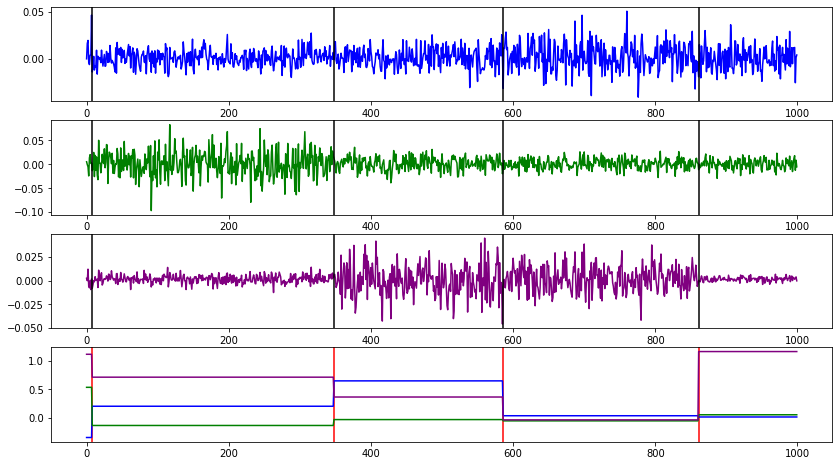

In [22]:
k = asset_returns_df.loc[asset_returns_df.index < 1000]
h = tangency_portfolios_df.loc[tangency_portfolios_df.index < 1000]
_breaks = filter(lambda x: x < 1000, breaks)


f, (ax1, ax2, ax3, axb) = plt.subplots(4,1, figsize=FIGSIZE)
ax1.plot(k['s_1'], color='blue')
ax2.plot(k['s_2'], color='green')
ax3.plot(k['s_3'], color='purple')

for b in _breaks:
    ax1.axvline(b, color='black')
    ax2.axvline(b, color='black')
    ax3.axvline(b, color='black')

    axb.axvline(b, color='red')

axb.plot(h['w_1'], color='blue')
axb.plot(h['w_2'], color='green')
axb.plot(h['w_3'], color='purple')




## Looking at returns

In [23]:
breaks_df = pd.DataFrame(breaks, columns = ['break_ix'])

In [24]:
# saving data!
df_name_returns = '..//data//simulated_returns.pickle'
df_name_tps = '..//data//simulated_tangency_portfolios.pickle'
df_name_breaks = '..//data//simulated_breaks_ix.pickle'
df_name_means = '..//data//simulated_means.pickle'
df_name_variances = '..//data//simulated_variances.pickle'

asset_returns_df.to_pickle(df_name_returns)
tangency_portfolios_df.to_pickle(df_name_tps)
breaks_df.to_pickle(df_name_breaks)
means_df.to_pickle(df_name_means)
variances_df.to_pickle(df_name_variances)

### Article deriving the efficient portfolio Frontier

Merton, Robert, 1972, An Analytic Derivation of the Efficient Portfolio Frontier, Journal of Financial and Quantitative Analysis